In [168]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [170]:
df = pd.read_csv("../data/cleaned data/merged_data.csv")
df = df.dropna()

In [172]:
characteristics = ["NumberofSchools", "DistrictEnrollment", "PercentofGiftedStudents",
        "CharterSchoolEnrollment", "GeographicSizeofDistrict", "AmericanIndian_AlaskanNative", "Asian", "NativeHawaiianorotherPacificIslander",
       "Black", "Hispanic", "White", "TwoOrMoreRaces", "EconomicallyDisadvantaged", "EnglishLearner", "SpecialEducation", "Female", "Male", 
       "Homeless", "MilitaryConnected", "perc_unconnected_students", "Latitude", "Longitude"]

In [174]:
# Separate districts with high and low time spent in person 
high_policy = df[df["In_Person"] > df["In_Person"].median()]
low_policy = df[df["In_Person"] <= df["In_Person"].median()]

# Perform spatial matching
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(low_policy[characteristics])

distances, indices = nn.kneighbors(high_policy[characteristics])
matched_pairs = pd.DataFrame({
    "high_policy_index": high_policy.index,
    "low_policy_index": low_policy.iloc[indices.flatten()].index,
    "distance": distances.flatten()
})

<Axes: xlabel='In_Person', ylabel='Count'>

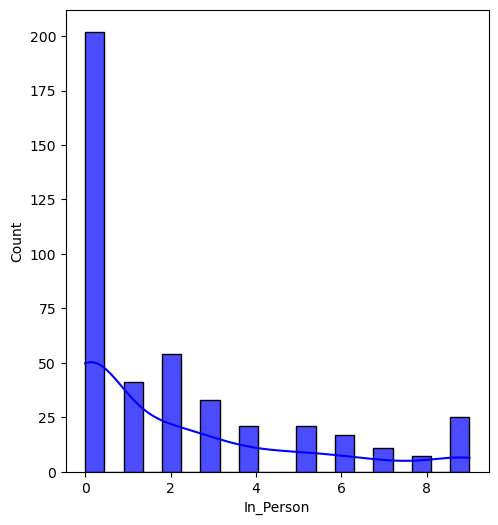

In [176]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df["In_Person"], kde=True, bins=20, color="blue", alpha=0.7)

In [178]:
# Add column for difference in test scores 
df["english_diff"] = df["mean_proficient_english_2022"] - df["mean_proficient_english_2019"]
df["math_diff"] = df["mean_proficient_math_2022"] - df["mean_proficient_math_2019"]

In [180]:
# Add test score differences for matched pairs
matched_pairs["english_diff_high"] = df.loc[matched_pairs["high_policy_index"], "english_diff"].values
matched_pairs["math_diff_high"] = df.loc[matched_pairs["high_policy_index"], "math_diff"].values
matched_pairs["english_diff_low"] = df.loc[matched_pairs["low_policy_index"], "english_diff"].values
matched_pairs["math_diff_low"] = df.loc[matched_pairs["low_policy_index"], "math_diff"].values

matched_pairs["english_diff_pairs"] = (
    df.loc[matched_pairs["high_policy_index"], "english_diff"].values -
    df.loc[matched_pairs["low_policy_index"], "english_diff"].values
)
matched_pairs["math_diff_pairs"] = (
    df.loc[matched_pairs["high_policy_index"], "math_diff"].values -
    df.loc[matched_pairs["low_policy_index"], "math_diff"].values
)

# Perform t-tests or difference of means
from scipy.stats import ttest_ind

english_scores = matched_pairs["english_diff_pairs"].dropna()
math_scores = matched_pairs["math_diff_pairs"].dropna()

english_ttest = ttest_ind(english_scores, [0] * len(english_scores))
math_ttest = ttest_ind(math_scores, [0] * len(math_scores))

print("English T-Test:", english_ttest)
print("Math T-Test:", math_ttest)


English T-Test: TtestResult(statistic=2.1775987193595165, pvalue=0.030057019786765674, df=376.0)
Math T-Test: TtestResult(statistic=2.427299640020905, pvalue=0.01568061117645827, df=376.0)


In [182]:
matched_pairs

,high_policy_index,low_policy_index,distance,english_diff_high,math_diff_high,english_diff_low,math_diff_low,english_diff_pairs,math_diff_pairs
0,15,77,3.675786,-9.111111,-4.944444,-3.481944,-4.309722,-5.629167,-0.634722
1,21,408,3.936410,-3.837500,-2.325000,-9.987500,-0.412500,6.150000,-1.912500
2,24,520,2.251223,-3.933333,-2.966667,-5.200000,-4.100000,1.266667,1.133333
3,28,361,3.598863,-3.300000,-3.700000,-6.866667,2.300000,3.566667,-6.000000
4,33,473,5.132482,-4.833333,-4.200000,-2.066667,-6.866667,-2.766667,2.666667
...,...,...,...,...,...,...,...,...,...
184,738,75,2.109739,-4.600000,0.750000,-8.450000,-5.950000,3.850000,6.700000
185,740,272,3.042653,-5.371429,-6.157143,-4.320000,-5.300000,-1.051429,-0.857143
186,741,170,2.676193,-6.650000,-1.550000,-1.750000,-4.250000,-4.900000,2.700000
187,743,550,2.095605,1.080000,0.680000,3.825000,-1.800000,-2.745000,2.480000


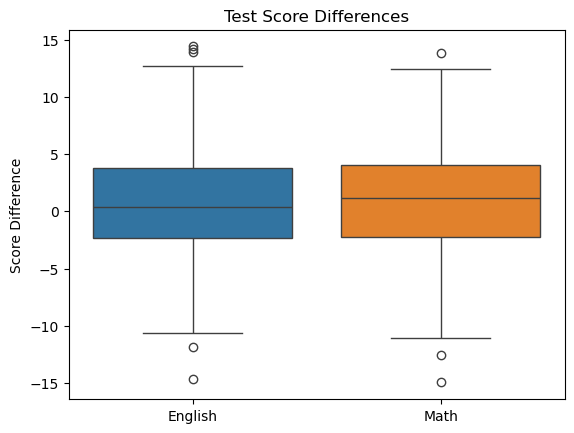

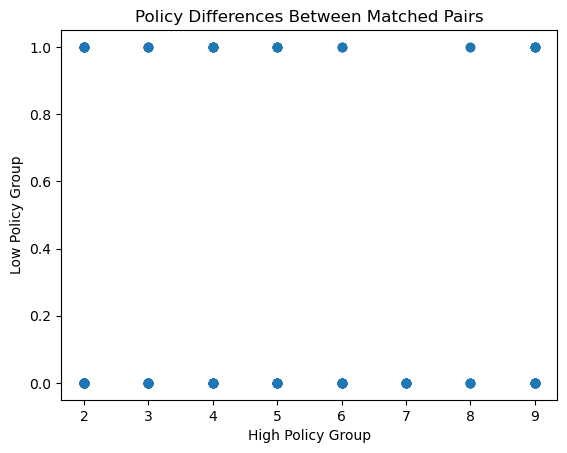

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of score differences
sns.boxplot(data=matched_pairs[["english_diff_pairs", "math_diff_pairs"]])
plt.title("Test Score Differences")
plt.ylabel("Score Difference")
plt.xticks([0, 1], ["English", "Math"])
plt.show()

# Scatter plot to visualize matches
plt.scatter(df.loc[matched_pairs["high_policy_index"], "In_Person"],
            df.loc[matched_pairs["low_policy_index"], "In_Person"])
plt.title("Policy Differences Between Matched Pairs")
plt.xlabel("High Policy Group")
plt.ylabel("Low Policy Group")
plt.show()

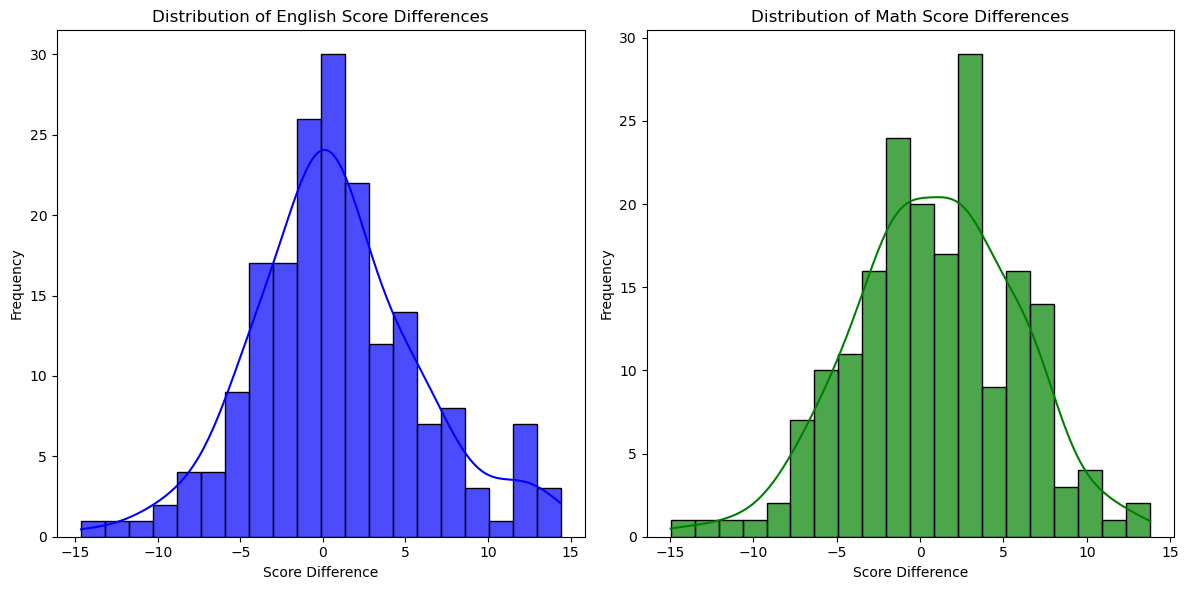

In [186]:
# Histogram of differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(matched_pairs["english_diff_pairs"], kde=True, bins=20, color="blue", alpha=0.7)
plt.title("Distribution of English Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(matched_pairs["math_diff_pairs"], kde=True, bins=20, color="green", alpha=0.7)
plt.title("Distribution of Math Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


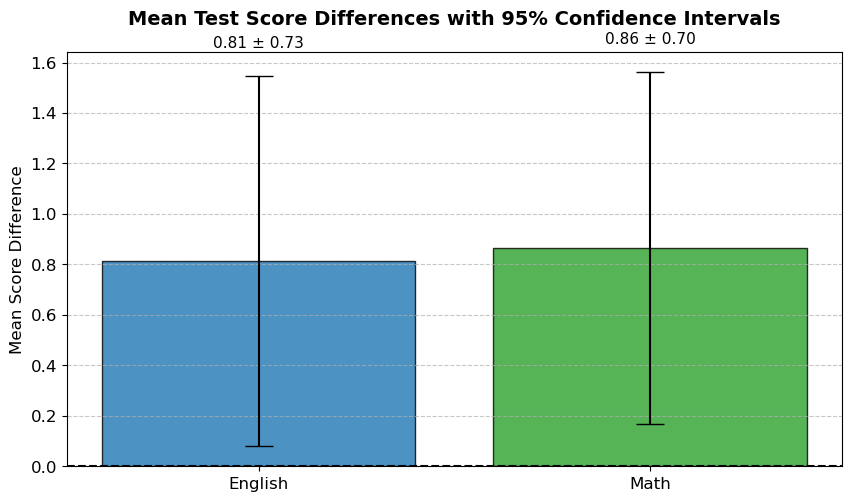

In [288]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean differences, standard deviations, and confidence intervals
mean_diffs = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].mean()
std_diffs = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].std()
sample_sizes = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].count()
conf_intervals = 1.96 * (std_diffs / sample_sizes ** 0.5)

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot the bar chart with error bars
bars = plt.bar(["English", "Math"], mean_diffs, yerr=conf_intervals, capsize=10, color=["#1f77b4", "#2ca02c"], alpha=0.8, edgecolor="black")

# Adding the title and labels
plt.title("Mean Test Score Differences with 95% Confidence Intervals", fontsize=14, fontweight='bold', pad=20)
plt.ylabel("Mean Score Difference", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add horizontal line at y=0 for reference
plt.axhline(0, color="black", linestyle="--", linewidth=1.5)

# Display the confidence interval values on top of the bars
for bar, ci in zip(bars, conf_intervals):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + ci + 0.1, f"{yval:.2f} ± {ci:.2f}", ha="center", va="bottom", fontsize=11, color="black")

# Enhance gridlines for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Adjust layout to prevent overlap
plt.subplots_adjust(top=0.8)

# Save the plot as a PNG file
plt.savefig("../figures/conf_intervals.png")

# Show the plot
plt.show()


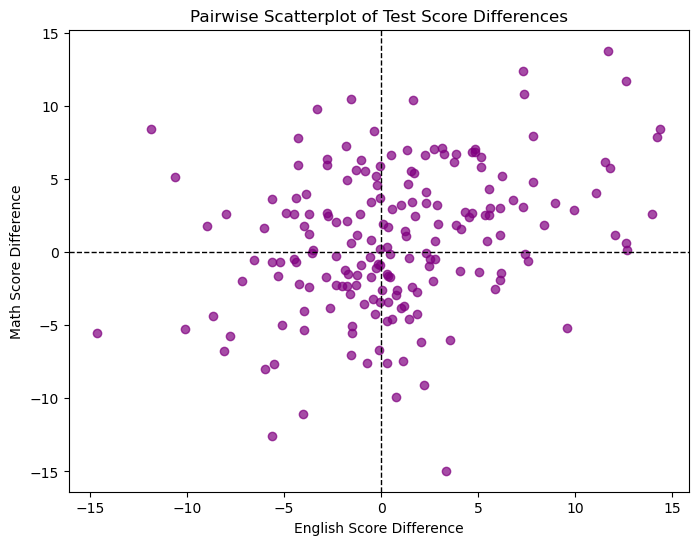

In [190]:
plt.figure(figsize=(8, 6))
plt.scatter(matched_pairs["english_diff_pairs"], matched_pairs["math_diff_pairs"], alpha=0.7, color="purple")
plt.title("Pairwise Scatterplot of Test Score Differences")
plt.xlabel("English Score Difference")
plt.ylabel("Math Score Difference")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

In [238]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles = "CartoDB Positron")  # Centered approximately on Pennsylvania

# Add matched pairs to the map
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add markers for each district
    folium.Marker(location=high_coords, popup="High Policy Group", icon=folium.Icon(color="blue")).add_to(map_pa)
    folium.Marker(location=low_coords, popup="Low Policy Group", icon=folium.Icon(color="green")).add_to(map_pa)

    # Add a line connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=2).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_map.html")
map_pa

In [194]:
matched_pairs.sort_values("english_diff_pairs", ascending = False)

,high_policy_index,low_policy_index,distance,english_diff_high,math_diff_high,english_diff_low,math_diff_low,english_diff_pairs,math_diff_pairs
121,501,31,3.037600,-0.083333,-5.233333,-14.480000,-13.640000,14.396667,8.406667
142,599,149,2.003381,0.100000,2.600000,-14.100000,-5.300000,14.200000,7.900000
15,81,149,2.532020,-0.150000,-2.650000,-14.100000,-5.300000,13.950000,2.650000
122,502,63,3.282656,-0.170000,-5.440000,-12.822222,-5.577778,12.652222,0.137778
70,302,75,1.986184,4.150000,-5.300000,-8.450000,-5.950000,12.600000,0.650000
...,...,...,...,...,...,...,...,...,...
164,670,427,1.979020,-9.700000,1.250000,-0.750000,-0.550000,-8.950000,1.800000
26,139,530,1.660586,-11.000000,-11.500000,-0.900000,-6.250000,-10.100000,-5.250000
20,124,12,2.207736,-8.850000,-2.050000,1.750000,-7.200000,-10.600000,5.150000
149,615,11,3.080224,-12.600000,-2.050000,-0.750000,-10.450000,-11.850000,8.400000


In [200]:
high_policy[high_policy["District Name"].str.contains("JEANNETTE")]

,District Name,DistrictType,Virtual,Hybrid,In_Person,mean_proficient_english_2019,mean_proficient_math_2019,mean_proficient_english_2022,mean_proficient_math_2022,Unnamed: 0,...,EconomicallyDisadvantaged,EnglishLearner,SpecialEducation,Female,Male,Homeless,MilitaryConnected,perc_unconnected_students,Latitude,Longitude
300,JEANNETTE CITY SCHOOL DISTRICT,Regular local school district,2.0,4.0,3.0,42.35,22.15,39.9,22.35,199.0,...,1.495097,-0.456224,1.464683,0.552867,-0.559297,-0.588581,-0.390646,2.309146,40.314335,-79.607893


In [166]:
high_policy

array([92.8, 0.9, 2.2, 46.2, 0.1, 2.7, 15.0], dtype=object)

In [60]:
high_policy.loc[501, ]

District Name                                            PENNCREST SCHOOL DISTRICT
DistrictType                                         Regular local school district
Virtual                                                                        0.0
Hybrid                                                                         2.0
In_Person                                                                      7.0
mean_proficient_english_2019                                             39.616667
mean_proficient_math_2019                                                     25.0
mean_proficient_english_2022                                             39.533333
mean_proficient_math_2022                                                19.766667
Unnamed: 0                                                                   325.0
NumberofSchools                                                                6.0
GradesOffered                           K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Dist

In [62]:
low_policy.loc[31, ]

District Name                                      BALD EAGLE AREA SCHOOL DISTRICT
DistrictType                                         Regular local school district
Virtual                                                                        0.0
Hybrid                                                                         0.0
In_Person                                                                      0.0
mean_proficient_english_2019                                                  54.5
mean_proficient_math_2019                                                    40.02
mean_proficient_english_2022                                                 40.02
mean_proficient_math_2022                                                    26.38
Unnamed: 0                                                                    18.0
NumberofSchools                                                                5.0
GradesOffered                           K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Dist

In [78]:
# Read in Data
district_facts = pd.read_excel("../data/raw data/DistrictFastFacts_20232024.xlsx")
internet_access = pd.read_csv("../data/raw data/DistrictMap.csv", encoding="utf-16", delimiter = "\t")

In [80]:
# Create column to join on 
district_facts["name"] = district_facts["DistrictName"].str.replace("SD", "School District")

In [82]:
# Merge Data 
joined_data = district_facts.merge(internet_access, on = "name", how = "left")
joined_data.head()

,DistrictName,AUN,DistrictAddress,DistrictAddressCity,DistrictAddressState,DistrictZipCode,Website,TelephoneNumber,NumberofSchools,GradesOffered,...,name,nces_code,district_id,county_name,city,locale,Max. frl_percent,num_students,perc_unconnected_students,sum_unconnected_students
0,Abington SD,123460302,970 Highland Ave,Abington,PA,19001,http://www.abington.k12.pa.us,215-884-4700,9,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Abington School District,4202040.0,953602.0,Montgomery County,ABINGTON,Suburban,26%,"8,126",9%,745
1,Abington Heights SD,119350303,200 E Grove St,Clarks Summit,PA,18411,http://www.ahsd.org,570-586-2511,6,"K5H, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Abington Heights School District,4202010.0,953601.0,Lackawanna County,CLARKS SUMMIT,Rural,20%,"3,304",7%,231
2,Albert Gallatin Area SD,101260303,2625 Morgantown Rd,Uniontown,PA,15401,http://www.agasd.org,724-564-7190,8,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Albert Gallatin Area School District,4202100.0,953603.0,Fayette County,UNIONTOWN,Rural,84%,"3,416",29%,"1,005"
3,Aliquippa SD,127040503,800 21st Street,Aliquippa,PA,15001,http://www.quipsd.org,724-857-7500,2,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Aliquippa School District,4202130.0,953604.0,Beaver County,ALIQUIPPA,Suburban,100%,"1,077",35%,377
4,Allegheny Valley SD,103020603,300 Pearl Ave,Cheswick,PA,15024,http://www.avsdweb.org,724-274-5300,2,"PreKF, K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Allegheny Valley School District,4202190.0,953605.0,Allegheny County,CHESWICK,Suburban,47%,943,17%,156


In [102]:
# Recode percentages
joined_data["perc_unconnected_students"] = joined_data["perc_unconnected_students"].str.rstrip('%').astype(float)

In [104]:
# low policy
bigbeaver = joined_data[joined_data["DistrictName"].str.contains("Big Beaver")]

In [124]:
bigbeaver

,DistrictName,AUN,DistrictAddress,DistrictAddressCity,DistrictAddressState,DistrictZipCode,Website,TelephoneNumber,NumberofSchools,GradesOffered,...,name,nces_code,district_id,county_name,city,locale,Max. frl_percent,num_students,perc_unconnected_students,sum_unconnected_students
35,Big Beaver Falls Area SD,127041503,1503 8th Avenue,Beaver Falls,PA,15010,http://www.tigerweb.org/,724-843-3470,4,"PreKF, K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Big Beaver Falls Area School District,4203630.0,953650.0,Beaver County,BEAVER FALLS,Suburban,98%,"1,744",35.0,602


In [126]:
# high policy 
jeanette = joined_data[joined_data["DistrictName"].str.contains("Jeannette")]

In [264]:
df

,District Name,DistrictType,Virtual,Hybrid,In_Person,mean_proficient_english_2019,mean_proficient_math_2019,mean_proficient_english_2022,mean_proficient_math_2022,Unnamed: 0,...,SpecialEducation,Female,Male,Homeless,MilitaryConnected,perc_unconnected_students,Latitude,Longitude,english_diff,math_diff
2,ABINGTON HEIGHTS SCHOOL DISTRICT,Regular local school district,1.0,8.0,0.0,51.080000,37.460000,46.000000,37.020000,1.0,...,-0.829856,0.138839,-0.146036,-0.942865,-0.579352,-1.228960,41.494201,-75.698738,-5.080000,-0.440000
3,ABINGTON SCHOOL DISTRICT,Regular local school district,2.0,7.0,0.0,47.787500,34.800000,41.975000,29.887500,0.0,...,-0.566116,0.207844,-0.214913,-0.588581,-0.013236,-0.966878,40.112391,-75.128542,-5.812500,-4.912500
9,ALBERT GALLATIN AREA SCHOOL DISTRICT,Regular local school district,2.0,7.0,0.0,40.185714,27.814286,40.557143,19.900000,2.0,...,1.939415,0.759880,-0.765928,-0.706676,-0.296294,1.653942,39.830060,-79.771237,0.371429,-7.914286
10,ALIQUIPPA SCHOOL DISTRICT,Regular local school district,6.0,2.0,1.0,20.800000,5.450000,19.150000,2.600000,3.0,...,0.647088,-0.482203,0.473857,-0.057154,-0.579352,2.440187,40.609438,-80.279389,-1.650000,-2.850000
11,ALLEGHENY VALLEY SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,43.200000,25.100000,42.450000,14.650000,4.0,...,0.383348,-2.276322,2.264657,-0.234296,-0.579352,0.081450,40.544106,-79.816428,-0.750000,-10.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,WYOMING AREA SCHOOL DISTRICT,Regular local school district,6.0,3.0,0.0,49.366667,31.800000,38.533333,19.333333,493.0,...,1.095446,1.173908,-1.110313,-0.588581,0.458527,-0.049591,41.321870,-75.811680,-10.833333,-12.466667
748,WYOMISSING AREA SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,45.366667,28.133333,42.666667,24.533333,495.0,...,-0.592490,0.828885,-0.834805,-0.942865,-0.579352,-0.704796,40.324122,-75.969888,-2.700000,-3.600000
750,YORK CITY SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,21.987500,9.187500,17.637500,5.750000,496.0,...,-0.144132,-0.344193,0.404980,5.434255,0.081117,2.440187,39.962134,-76.732066,-4.350000,-3.437500
752,YORK SUBURBAN SCHOOL DISTRICT,Regular local school district,0.0,8.0,1.0,45.500000,30.833333,42.633333,30.133333,497.0,...,-1.383711,-0.758221,0.749364,-0.057154,-0.579352,-0.573755,39.948671,-76.692170,-2.866667,-0.700000


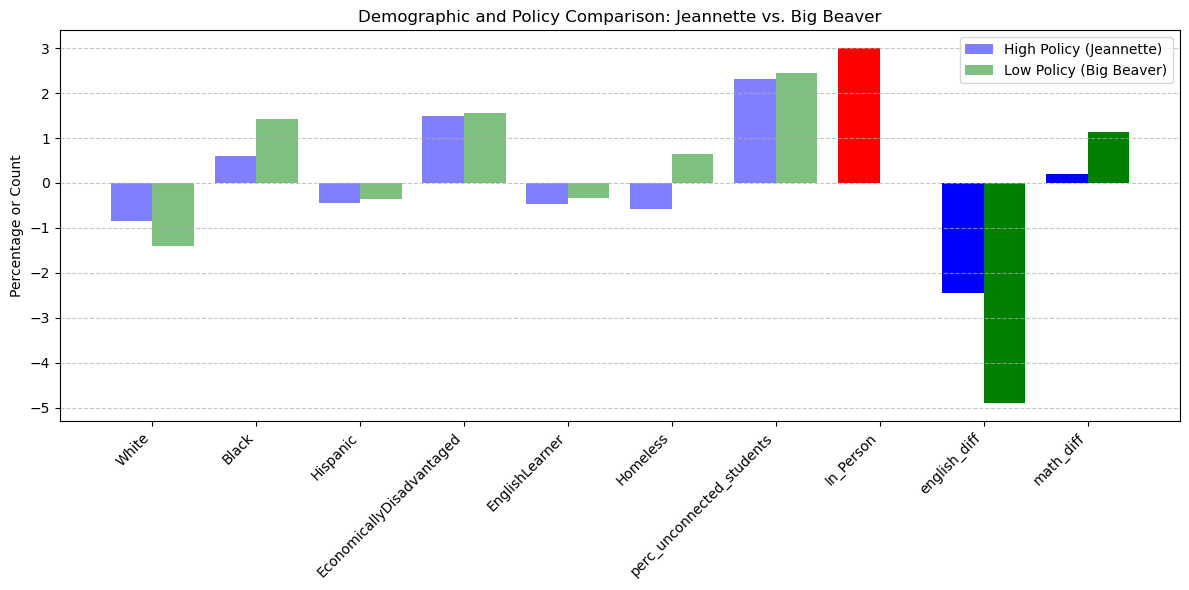

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Filter rows for the two districts
jeanette = df[df["District Name"].str.contains("JEANNETTE")].iloc[0]  # Extract the first row as Series
bigbeaver = df[df["District Name"].str.contains("BIG BEAVER")].iloc[0]  # Extract the first row as Series

# Define the columns of interest
labels = [
    "White", "Black", "Hispanic", 
    "EconomicallyDisadvantaged", "EnglishLearner", "Homeless", "perc_unconnected_students", 
    "In_Person", "english_diff", "math_diff"
]

# Extract data for plotting
high_policy = jeanette[labels].values  # Extract values for Jeannette
low_policy = bigbeaver[labels].values  # Extract values for Big Beaver

x = np.arange(len(labels))  # Generate x positions for each label
bar_width = 0.4  # Width of each bar

# Define colors and alpha for fading and highlighting
faded_color_high = "blue"
faded_color_low = "green"
highlight_color = "red"

colors_high = [highlight_color if label == "In_Person" else faded_color_high for label in labels]
colors_low = [highlight_color if label == "In_Person" else faded_color_low for label in labels]
alphas = [1 if label in ["In_Person", "english_diff", "math_diff"] else 0.5 for label in labels]

# Create the plot
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the bars with adjusted colors and alpha
for i in range(len(labels)):
    plt.bar(x[i] - bar_width / 2, high_policy[i], width=bar_width, color=colors_high[i], alpha=alphas[i], label="High Policy (Jeannette)" if i == 0 else "")
    plt.bar(x[i] + bar_width / 2, low_policy[i], width=bar_width, color=colors_low[i], alpha=alphas[i], label="Low Policy (Big Beaver)" if i == 0 else "")

# Customize the plot
plt.xticks(x, labels, rotation=45, ha="right")  # Adjust x-axis labels to align between bars
plt.ylabel("Percentage or Count")
plt.title("Demographic and Policy Comparison: Jeannette vs. Big Beaver")
plt.legend()

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits
plt.tight_layout()  # Ensure labels and titles fit within the figure

# Save and show the plot
plt.savefig("../figures/jeannette_bigbeaver_highlighted.png")
plt.show()


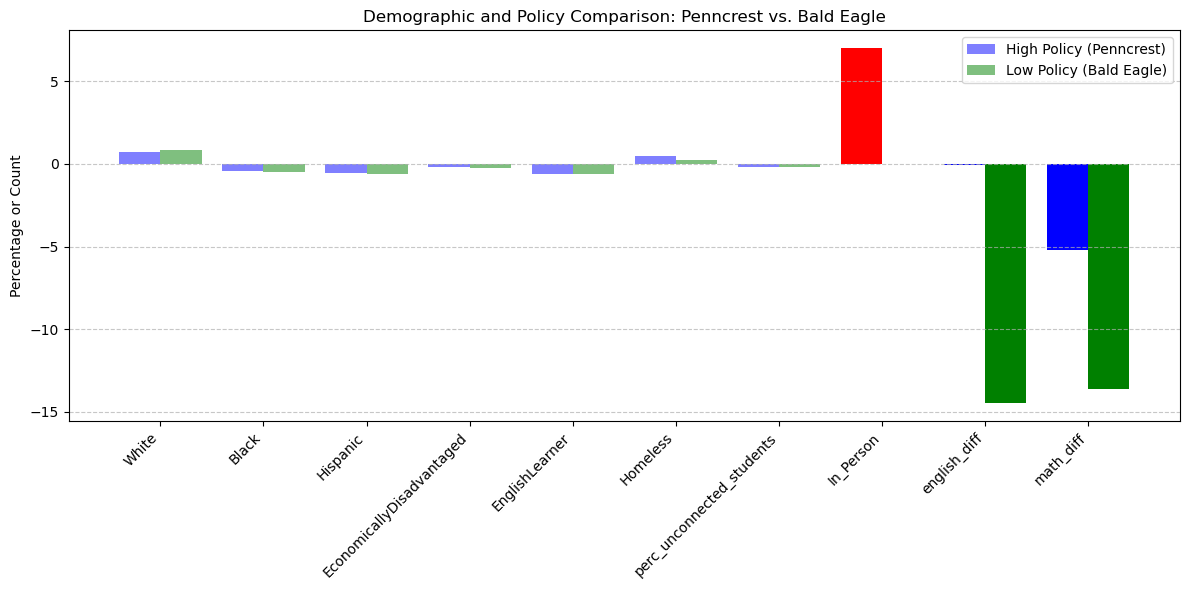

In [276]:
import matplotlib.pyplot as plt
import numpy as np

# Filter rows for the two districts
jeanette = df[df["District Name"].str.contains("PENNCREST")].iloc[0]  # Extract the first row as Series
bigbeaver = df[df["District Name"].str.contains("BALD EAGLE")].iloc[0]  # Extract the first row as Series

# Define the columns of interest
labels = [
    "White", "Black", "Hispanic", 
    "EconomicallyDisadvantaged", "EnglishLearner", "Homeless", "perc_unconnected_students", 
    "In_Person", "english_diff", "math_diff"
]

# Extract data for plotting
high_policy = jeanette[labels].values  # Extract values for Jeannette
low_policy = bigbeaver[labels].values  # Extract values for Big Beaver

x = np.arange(len(labels))  # Generate x positions for each label
bar_width = 0.4  # Width of each bar

# Define colors and alpha for fading and highlighting
faded_color_high = "blue"
faded_color_low = "green"
highlight_color = "red"

colors_high = [highlight_color if label == "In_Person" else faded_color_high for label in labels]
colors_low = [highlight_color if label == "In_Person" else faded_color_low for label in labels]
alphas = [1 if label in ["In_Person", "english_diff", "math_diff"] else 0.5 for label in labels]

# Create the plot
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the bars with adjusted colors and alpha
for i in range(len(labels)):
    plt.bar(x[i] - bar_width / 2, high_policy[i], width=bar_width, color=colors_high[i], alpha=alphas[i], label="High Policy (Penncrest)" if i == 0 else "")
    plt.bar(x[i] + bar_width / 2, low_policy[i], width=bar_width, color=colors_low[i], alpha=alphas[i], label="Low Policy (Bald Eagle)" if i == 0 else "")

# Customize the plot
plt.xticks(x, labels, rotation=45, ha="right")  # Adjust x-axis labels to align between bars
plt.ylabel("Percentage or Count")
plt.title("Demographic and Policy Comparison: Penncrest vs. Bald Eagle")
plt.legend()

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits
plt.tight_layout()  # Ensure labels and titles fit within the figure

# Save and show the plot
plt.savefig("../figures/penncrest_baldeagle_highlighted.png")
plt.show()


In [224]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles="CartoDB Positron")  # Centered approximately on Pennsylvania

# Define coordinates for highlighted pairs (Jeannette and Big Beaver)
highlighted_pairs = [
    {"high_policy_index": "Jeannette", "low_policy_index": "Big Beaver"}
]

# Add all matched pairs to the map with smaller circles and muted colors
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add smaller circles for non-highlighted districts
    folium.CircleMarker(location=high_coords, radius=4, color="lightblue", fill=True, fill_opacity=0.5).add_to(map_pa)
    folium.CircleMarker(location=low_coords, radius=4, color="lightgreen", fill=True, fill_opacity=0.5).add_to(map_pa)

    # Add muted lines connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="gray", weight=1, opacity=0.4).add_to(map_pa)

# Highlight the selected pairs (Jeannette and Big Beaver) with larger circles
for pair in highlighted_pairs:
    # Get coordinates for the highlighted districts
    high_coords = df.loc[df["District Name"].str.contains(pair["high_policy_index"].upper()), ["Latitude", "Longitude"]].values[0]
    low_coords = df.loc[df["District Name"].str.contains(pair["low_policy_index"].upper()), ["Latitude", "Longitude"]].values[0]

    # Add large circles for highlighted districts
    folium.CircleMarker(
        location=high_coords, 
        radius=10,  # Larger radius for emphasis
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.9,
        popup="Highlighted: High Policy Group (Jeannette)"
    ).add_to(map_pa)

    folium.CircleMarker(
        location=low_coords, 
        radius=10,  # Larger radius for emphasis
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.9,
        popup="Highlighted: Low Policy Group (Big Beaver)"
    ).add_to(map_pa)

    # Add bold lines connecting the highlighted districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=3).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_highlighted_map_large.html")
map_pa


In [244]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles="CartoDB Positron")  # Centered approximately on Pennsylvania

# Define coordinates for highlighted pairs (Jeannette and Big Beaver)
highlighted_pairs = [
    {"high_policy_index": "Penncrest", "low_policy_index": "Bald Eagle"}
]

# Add all matched pairs to the map with smaller circles and muted colors
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add smaller circles for non-highlighted districts
    folium.CircleMarker(location=high_coords, radius=4, color="lightblue", fill=True, fill_opacity=0.5).add_to(map_pa)
    folium.CircleMarker(location=low_coords, radius=4, color="lightgreen", fill=True, fill_opacity=0.5).add_to(map_pa)

    # Add muted lines connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="gray", weight=1, opacity=0.4).add_to(map_pa)

# Highlight the selected pairs (Jeannette and Big Beaver) with larger circles
for pair in highlighted_pairs:
    # Get coordinates for the highlighted districts
    high_coords = df.loc[df["District Name"].str.contains(pair["high_policy_index"].upper()), ["Latitude", "Longitude"]].values[0]
    low_coords = df.loc[df["District Name"].str.contains(pair["low_policy_index"].upper()), ["Latitude", "Longitude"]].values[0]

    # Add large circles for highlighted districts
    folium.CircleMarker(
        location=high_coords, 
        radius=10,  # Larger radius for emphasis
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.9,
        popup="Highlighted: High Policy Group (Jeannette)"
    ).add_to(map_pa)

    folium.CircleMarker(
        location=low_coords, 
        radius=10,  # Larger radius for emphasis
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.9,
        popup="Highlighted: Low Policy Group (Big Beaver)"
    ).add_to(map_pa)

    # Add bold lines connecting the highlighted districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=3).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_highlighted_map_large.html")
map_pa
